# Import


In [80]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras


# LOAD DATA 

## Labélisation des données

In [82]:
df = pd.read_csv('datasetiot.csv')
# keep 100 000 first rows
df = df.iloc[:100000]
# add columns empty columns to the dataframe this will be used to store the labels
df['label'] = np.nan
df['label'] = df['label'].astype('category')
#set category types
df['label'].cat.set_categories(['Normal', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)

# line 0 to 5150 is FTP traffic
df.loc[0:5150, 'label'] = 'Normal'
# line 5151 to 18600 is SSH traffic
df.loc[5151:18600, 'label'] = 'Normal'
# line 18601 to 28000 is FTP + SSH traffic
df.loc[18601:28000, 'label'] = 'Normal'
# line 28000 to 40100 is Keylogger traffic
df.loc[28000:40100, 'label'] = 'Keylogger'
# line 40101 to 46500 is FTP + SSH 
df.loc[40101:46500, 'label'] = 'Normal'
# line 46501 to 54100 is Reverse Shell
df.loc[46501:54100, 'label'] = 'Reverse Shell'
# line 54101 to 57150 is FTP + SSH
df.loc[54101:57150, 'label'] = 'Normal'
# the rest is syn flood
df.loc[57151:, 'label'] = 'SYN Flood'
# merge label SSH and FTP + SSH and FTP as "Normal"



C:\Users\enzoh\AppData\Local\Temp\ipykernel_14860\1072877512.py:8: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['label'].cat.set_categories(['Normal', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)


## Quelques visualisations

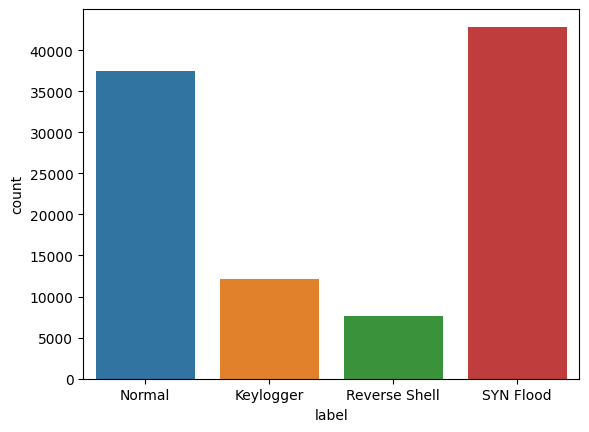

In [ ]:
# plot diffrent features
# plot the distribution of the label
sns.countplot(x='label', data=df)
plt.show()
    

In [ ]:
# print all features
print(df.columns)

Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info',
       'label'],
      dtype='object')


## Preprocessing


In [83]:
# preprocess the data
# drop the columns that are not needed "No" , "Time"
df = df.drop(['No.', 'Time'], axis=1)


In [ ]:
df.head()

,Source,Destination,Protocol,Length,Info,label
0,192.168.174.1,239.255.255.250,SSDP,166,M-SEARCH * HTTP/1.1,Normal
1,192.168.174.1,239.255.255.250,SSDP,171,M-SEARCH * HTTP/1.1,Normal
2,172.16.0.1,239.255.255.250,SSDP,166,M-SEARCH * HTTP/1.1,Normal
3,172.16.0.1,239.255.255.250,SSDP,171,M-SEARCH * HTTP/1.1,Normal
4,192.168.174.1,239.255.255.250,SSDP,166,M-SEARCH * HTTP/1.1,Normal


In [84]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df.head()

# convert categorical data to numerical data
df['Protocol'] = df['Protocol'].astype('category')
df['Protocol'] = df['Protocol'].cat.codes
df['Source'] = df['Source'].astype('category')
df['Source'] = df['Source'].cat.codes
df['Destination'] = df['Destination'].astype('category')
df['Destination'] = df['Destination'].cat.codes
df['Info'] = df['Info'].astype('category')
df['Info'] = df['Info'].cat.codes
df.head()



,Source,Destination,Protocol,Length,Info,label
0,10155,11194,13,166,76629,1
1,10155,11194,13,171,76629,1
2,8070,11194,13,166,76629,1
3,8070,11194,13,171,76629,1
4,10155,11194,13,166,76629,1


In [85]:
# print all values of the label
print(df['label'].unique())
# print count of each label
print(df['label'].value_counts())

[1 0 2 3]
3    42849
1    37450
0    12101
2     7600
Name: label, dtype: int64


## Création des données d'entrainement et de test

In [92]:
def format_data_time_step(data, time_step):
    train_indices = [(0, 3500), (5150, 13000), (18600, 24500), (28000, 35000), (40100, 44000), (46500, 51500), (54101, int((len(data))*0.7))]
    val_indices = [(3501, 4300), (13001, 15500), (24501, 26500), (35001, 37500), (44000, 45250), (51501, 52750), (int((len(data))*0.7), int((len(data))*0.85))]
    test_indices = [(4301, 5150), (15501, 18600), (26501, 28000), (37501, 40100), (45251, 46500), (52750, 54100), (int((len(data))*0.85), len(data))]

    # create the training, validation, and test dataframes, including the parts inside each tuple
    train_df = pd.concat([data.iloc[start:end] for start, end in train_indices])
    val_df = pd.concat([data.iloc[start:end] for start, end in val_indices])
    test_df = pd.concat([data.iloc[start:end] for start, end in test_indices])

    train_df = train_df.drop(['label'], axis=1)
    train_labels = train_df['label']

    val_df = val_df.drop(['label'], axis=1)
    val_labels = val_df['label']

    test_data = test_df.drop(['label'], axis=1)
    test_labels = test_data['label']

    # print the shape of the dataframes
    print(train_df.shape)
    print(val_df.shape)
    print(test_df.shape)

    # convert the dataframes to numpy arrays
    train_df = np.array(train_df)
    train_labels = np.array(train_labels)
    val_df = np.array(val_df)

    val_labels = np.array(val_labels)
    test_df = np.array(test_df)
    test_labels = np.array(test_labels)

    # reshape the data to be in the shape of (samples, time steps, features)
    train_df = train_df.reshape((train_df.shape[0], time_step, train_df.shape[1]))
    val_df = val_df.reshape((val_df.shape[0], time_step, val_df.shape[1]))
    test_df = test_df.reshape((test_df.shape[0], time_step, test_df.shape[1]))

    return train_df, train_labels, val_df, val_labels, test_df, test_labels


In [93]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = format_data_time_step(df, 100)



KeyError: 'label'